# Home assignment 5

This journal covers the home assignment 5. 

We start with loading the modules that we would need:

In [123]:
# set up the environment
# some of these packages are not required, 
# I like to keep the stuff I use under the comments and uncomment it whenever I need it

# pandas is the module that deals with storing data in a structured way; think of it as excel and sql for python
import pandas as pd
# Display 5 columns for viewing purposes
# pd.set_option('display.max_columns', 5)
# Reduce decimal points to 2
pd.options.display.float_format = '{:,.2f}'.format


# numpy is for all the numerical stuff 
import numpy as np
# this package is useful for importing RData files 
# to install it run: pip install pyreadr
# import pyreadr

import glob

# import statistical tools (these include regressions that we'll run to estimate the production function)
import scipy as sp
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from linearmodels.panel import PanelOLS

from sklearn.preprocessing import PolynomialFeatures

# import seaborn as sns
# import locale
# from sklearn.decomposition import PCA
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn.metrics import mean_squared_error

# sns.set_theme(style="darkgrid")

# matplotlib is for plotting pretty figures and pictures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
# plt.rcParams['text.usetex'] = True

# this is to tell python where TeX distribution is in case you need to use LaTeX in your figures
import os
# os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

Now we are ready to load the data. This will be done using a function from `panda` package

In [4]:
#import the data from csv
data_path = "/Users/uctpnr1/Library/CloudStorage/Dropbox/teaching/ECON0072/2023-24/data" # path to data files
data_files = glob.glob(os.path.join(data_path, "firmData0072*.csv")) #get a list of all the files in case there are several
raw_data = pd.concat((pd.read_csv(f) for f in data_files), ignore_index=True) #load and concatenate them using a loop
raw_data.head() #display the first 20 lines of the dataset

# import the data from RData using pyreadr
# rdataset = pyreadr.read_r(os.path.join(data_path, "firmData0072.RData")) # load the dataset
# raw_data_r = rdataset["firmData"]
# raw_data_r.head()

/var/folders/4k/p7rsnnm96fd508_m4vd1ycr80000gn/T/ipykernel_89112/1677799344.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.concat((pd.read_csv(f) for f in data_files), ignore_index=True) #load and concatenate them using a loop


,Unnamed: 0,company_name,inactive,quoted,branch,owndata,woco,ro_full_postcode,registered_number,primary_uk_sic_2007_code,...,remuneration_th_gbp_2021,remuneration_th_gbp_2020,remuneration_th_gbp_2019,remuneration_th_gbp_2018,remuneration_th_gbp_2017,number_of_employees_2021,number_of_employees_2020,number_of_employees_2019,number_of_employees_2018,number_of_employees_2017
0,1,LIVERPOOL LAND SECURITIES LIMITED,No,No,No,No,No,L38 3RT,"963,687.00","68,209.00",...,NaN,NaN,NaN,NaN,NaN,3.00,4.00,4.00,NaN,NaN
1,2,LESTERWAY RESIDENTS ASSOCIATION LIMITED,No,No,No,No,No,SW15 2LL,"2,501,911.00","98,000.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,3.00
2,3,RAMPANT DRAGON LIMITED,No,No,No,No,No,LL13 8LW,"5,299,664.00","68,209.00",...,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,NaN
3,4,MCDOWALL PROPERTY SERVICES LTD,No,No,No,No,No,NE21 6DD,"7,395,858.00","33,190.00",...,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN
4,5,FIL09 LIMITED,No,No,No,No,No,IG8 7DU,"7,117,497.00","43,390.00",...,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN


In [5]:
# drop all the observations for which turnover_th_gbp_2017 is missing; inplace=True would prevent the code from creating a new dataframe
raw_data.dropna(subset=['turnover_th_gbp_2017'], inplace=True)
# create an index column for your data, we'll use it when transforming the panel into a long form
raw_data["id"] = raw_data.index
# create a list of all variables that are measured in different years
measured_outcomes = []
for x in list(raw_data.columns):
    if len(x)>4 and x[-4]=="2":
        measured_outcomes.append(x[:-4])
measured_outcomes = list(dict.fromkeys(measured_outcomes)) # remove all duplicates

#convert the panel into the long form
data_long = pd.wide_to_long(raw_data, measured_outcomes, i="id", j="year")
data_long.sort_values("id", inplace=True)

print(measured_outcomes)
#data_long.reset_index(inplace=True) #this resets the index and gets rid of MultiIndex
data_long.head(10)

['tangible_assets_th_gbp_', 'land__buildings_th_gbp_', 'fixtures__fittings_th_gbp_', 'plant__vehicles_th_gbp_', 'other_fixed_assets_th_gbp_', 'intangible_assets_th_gbp_', 'investments_fixed_assets_th_gbp_', 'fixed_assets_th_gbp_', 'turnover_th_gbp_', 'cost_of_sales_th_gbp_', 'administration_expenses_th_gbp_', 'operating_profit_th_gbp_', 'remuneration_th_gbp_', 'number_of_employees_']


primary_trading_address_postcode  \
id year                                    
38 2021                             YO12   
   2020                             YO12   
   2019                             YO12   
   2018                             YO12   
   2017                             YO12   
51 2019                              NaN   
   2018                              NaN   
   2020                              NaN   
   2021                              NaN   
   2017                              NaN   

                                         trade_description inactive woco  \
id year                                                                    
38 2021  Sells calendars and novelty items to raise fun...       No   No   
   2020  Sells calendars and novelty items to raise fun...       No   No   
   2019  Sells calendars and novelty items to raise fun...       No   No   
   2018  Sells calendars and novelty items to raise fun...       No   No   
   2017  Sells calendars and novelty items to raise fun...       No   No   
51 2019  Retailing of entertainment and general merchan...       No   No   
   2018  Retailing of entertainment and general merchan...       No   No   
   2020  Retailing of entertainment and general merchan...       No   No   
   2021  Retailing of entertainment and general merchan...       No   No   
   2017  Retailing of entertainment and general merchan...       No   No   

                                     primary_business_line  \
id year                                                      
38 2021                                                NaN   
   2020                                                NaN   
   2019                                                NaN   
   2018                                                NaN   
   2017                                                NaN   
51 2019  Engaged in the retail sale of digital video di...   
   2018  Engaged in the retail sale of digital video di...   
   2020  Engaged in the retail sale of digital video di...   
   2021  Engaged in the retail sale of digital video di...   
   2017  Engaged in the retail sale of digital video di...   

                              company_name  \
id year                                      
38 2021  SCARBOROUGH HOSPICE SALES LIMITED   
   2020  SCARBOROUGH HOSPICE SALES LIMITED   
   2019  SCARBOROUGH HOSPICE SALES LIMITED   
   2018  SCARBOROUGH HOSPICE SALES LIMITED   
   2017  SCARBOROUGH HOSPICE SALES LIMITED   
51 2019              RAREWAVES.COM LIMITED   
   2018              RAREWAVES.COM LIMITED   
   2020              RAREWAVES.COM LIMITED   
   2021              RAREWAVES.COM LIMITED   
   2017              RAREWAVES.COM LIMITED   

                           primary_uk_sic_2007_description  Unnamed: 0  \
id year                                                                  
38 2021        Other retail sale in non-specialised stores          39   
   2020        Other retail sale in non-specialised stores          39   
   2019        Other retail sale in non-specialised stores          39   
   2018        Other retail sale in non-specialised stores          39   
   2017        Other retail sale in non-specialised stores          39   
51 2019  Retail sale via mail order houses or via Internet          52   
   2018  Retail sale via mail order houses or via Internet          52   
   2020  Retail sale via mail order houses or via Internet          52   
   2021  Retail sale via mail order houses or via Internet          52   
   2017  Retail sale via mail order houses or via Internet          52   

         all_uk_sic_2007_codes registered_number  ...  \
id year                                           ...   
38 2021              47,190.00      2,053,320.00  ...   
   2020              47,190.00      2,053,320.00  ...   
   2019              47,190.00      2,053,320.00  ...   
   2018              47,190.00      2,053,320.00  ...   
   2017              47,190.00      2

/Users/uctpnr1/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


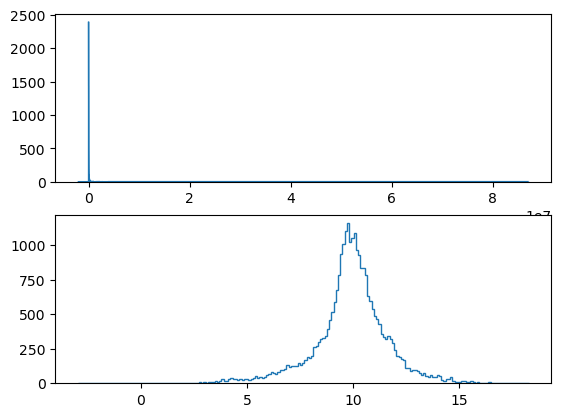

In [6]:
# create the revenue variable and check out its distribution

data_long["revenue"] = data_long["operating_profit_th_gbp_"]-data_long["cost_of_sales_th_gbp_"]-data_long["administration_expenses_th_gbp_"]+data_long["remuneration_th_gbp_"]
data_long["log_revenue"] = np.log(data_long["operating_profit_th_gbp_"]-data_long["cost_of_sales_th_gbp_"]-data_long["administration_expenses_th_gbp_"]+data_long["remuneration_th_gbp_"])

fig, ax = plt.subplots(2)
counts, bins = np.histogram(list(data_long.dropna(subset=['revenue'], inplace=False)["revenue"]),bins='auto')
ax[0].stairs(counts, bins)
counts, bins = np.histogram(list(data_long.dropna(subset=['log_revenue'], inplace=False)["log_revenue"]),bins='auto')
ax[1].stairs(counts, bins)


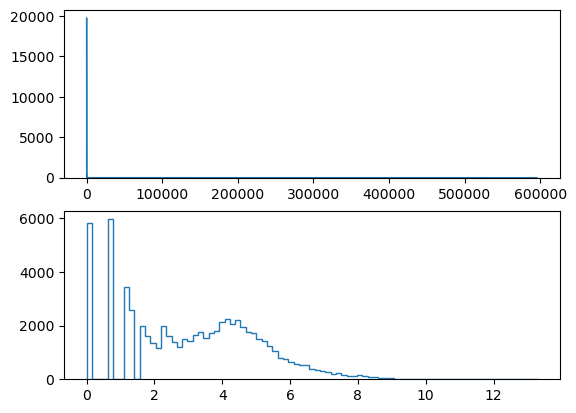

In [7]:
# Labor

data_long["log_employees"] = np.log(data_long["number_of_employees_"])

fig, ax = plt.subplots(2)
counts, bins = np.histogram(list(data_long.dropna(subset=['number_of_employees_'], inplace=False)["number_of_employees_"]),bins='auto')
ax[0].stairs(counts, bins)
counts, bins = np.histogram(list(data_long.dropna(subset=['log_employees'], inplace=False)["log_employees"]),bins='auto')
ax[1].stairs(counts, bins)

/Users/uctpnr1/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


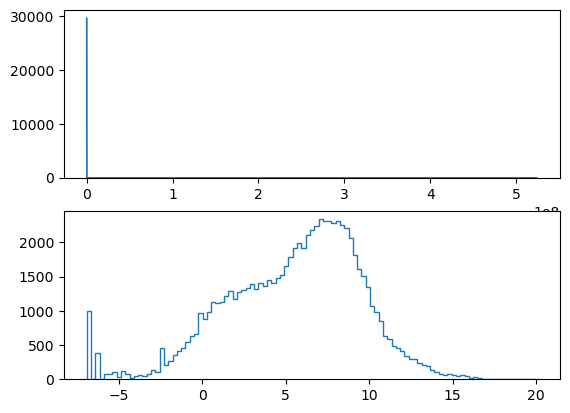

In [8]:
# Fixed assets

data_long["log_assets"] = np.log(data_long["fixed_assets_th_gbp_"])

fig, ax = plt.subplots(2)
counts, bins = np.histogram(list(data_long.dropna(subset=['fixed_assets_th_gbp_'], inplace=False)["fixed_assets_th_gbp_"]),bins='auto')
ax[0].stairs(counts, bins)
counts, bins = np.histogram(list(data_long.dropna(subset=['log_assets'], inplace=False)["log_assets"]),bins='auto')
ax[1].stairs(counts, bins)

### Estimating Cobb-Douglas production function

In [9]:
# drop all the observations for which turnover_th_gbp_2017 is missing; inplace=True would prevent the code from creating a new dataframe
data_long.dropna(subset=["log_revenue"], inplace=True)
data_long.dropna(subset=["log_assets"], inplace=True)
data_long.dropna(subset=["log_employees"], inplace=True)

In [10]:
# pool model (firm-year pair is an independent observation)
model_expr = "log_revenue~log_employees+log_assets"
model_pool = smf.ols(formula=model_expr, data=data_long)
model_pool_results = model_pool.fit()
print(model_pool_results.summary())


                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 2.021e+04
Date:                Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:31:19   Log-Likelihood:                -36902.
No. Observations:               26079   AIC:                         7.381e+04
Df Residuals:                   26076   BIC:                         7.383e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0742      0.021    289.627

In [11]:
print(model_pool_results.f_test("log_assets + log_employees = 1")) # The F-test rejects the hypothesis that elasticities for K and L add to 1

<F test: F=2518.584342510713, p=0.0, df_denom=2.61e+04, df_num=1>


In [12]:
# model for 2017 year only; the results seem stable
data_temp = data_long.reset_index()
model_expr = "log_revenue~log_employees+log_assets"
data_2017  = data_temp.loc[data_temp["year"]==2017]
model_2017 = smf.ols(formula=model_expr, data=data_2017)
model_2017_results = model_2017.fit()
print(model_2017_results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     5836.
Date:                Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:31:29   Log-Likelihood:                -9671.4
No. Observations:                6824   AIC:                         1.935e+04
Df Residuals:                    6821   BIC:                         1.937e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9446      0.039    151.781

In [11]:
# pool model, translog (firm-year pair is an independent observation)
data_long["log_assets2"] = np.power(data_long["log_assets"],2)
data_long["log_employees2"] = np.power(data_long["log_employees"],2)
data_long["log_employees_log_assets"] = np.multiply(data_long["log_employees"],data_long["log_assets"])
model_expr = "log_revenue~log_employees+log_assets+log_employees2+log_assets2+log_employees_log_assets"
model_pool = smf.ols(formula=model_expr, data=data_long)
model_pool_results = model_pool.fit()
print(model_pool_results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     8255.
Date:                Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:43:26   Log-Likelihood:                -36733.
No. Observations:               26079   AIC:                         7.348e+04
Df Residuals:                   26073   BIC:                         7.353e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [13]:
# FE model
model_fe = PanelOLS(dependent=data_long["log_revenue"],
             exog=data_long[["log_employees","log_assets"]],
             entity_effects=True,
             time_effects=True)
fe_res = model_fe.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_revenue   R-squared:                        0.2162
Estimator:                   PanelOLS   R-squared (Between):              0.4873
No. Observations:               26079   R-squared (Within):               0.2180
Date:                Sun, Feb 18 2024   R-squared (Overall):              0.4929
Time:                        21:43:46   Log-likelihood                   -334.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2576.8
Entities:                        7386   P-value                           0.0000
Avg Obs:                       3.5309   Distribution:                 F(2,18687)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2576.8
                            

### OP(1992) implementation

This is the simplest (and therefore very inefficient) way of implementing the OP(1992) method. It uses two stages and the second stage is a simple 2SLS.

In [114]:
data_long["log_investments"] = np.log(data_long["investments_fixed_assets_th_gbp_"])
data_long.dropna(subset=["log_investments"], inplace=True)
data_long.sort_values(["id", "year"], ascending=True, inplace=True)
data_op = data_long[["log_revenue","log_employees","log_assets","log_investments"]]

# First stage
poly = PolynomialFeatures(2) #set polynomial of degree 2
Phi_variables = poly.fit_transform(data_op[["log_investments","log_assets"]])
Phi_variables_labels = poly.get_feature_names_out(["log_investments","log_assets"])
for i, s in enumerate(Phi_variables_labels):
    Phi_variables_labels[i]=Phi_variables_labels[i].replace(" ", "_")
    Phi_variables_labels[i]=Phi_variables_labels[i].replace("^", "_")
Phi_data = pd.DataFrame(data=Phi_variables, columns=Phi_variables_labels, index=data_op.index)

data_first_stage = data_op[["log_revenue","log_employees"]].merge(Phi_data,how="left",on=["id","year"])
model_expr = "log_revenue~log_employees"
for x in Phi_variables_labels:
    model_expr += "+"+x
print(model_expr)
model_fs = smf.ols(formula=model_expr, data=data_first_stage)
model_fs_results = model_fs.fit()
print(model_fs_results.summary())


log_revenue~log_employees+1+log_investments+log_assets+log_investments_2+log_investments_log_assets+log_assets_2
                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     3418.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:10:27   Log-Likelihood:                -15041.
No. Observations:               10858   AIC:                         3.010e+04
Df Residuals:                   10851   BIC:                         3.015e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--

In [115]:

# Second stage
params_fs = model_fs_results.params.copy()
params_fs["log_employees"] = 0
y = pd.DataFrame(model_fs.predict(params_fs),columns=["log_revenue_hat"],index=data_op.index)

poly2 = PolynomialFeatures(2) #set polynomial of degree 2
G_variables = poly2.fit_transform(y[["log_revenue_hat"]])
G_variables_labels = poly2.get_feature_names_out(["log_revenue_hat"])
for i, s in enumerate(G_variables_labels):
    G_variables_labels[i]=G_variables_labels[i].replace(" ", "_")
    G_variables_labels[i]=G_variables_labels[i].replace("^", "_")
G_data = pd.DataFrame(data=G_variables, columns=G_variables_labels, index=data_op.index)
data_op = data_op.merge(G_data,how="left",on=["id","year"])

# create lagged variables
lagged_data = data_op.groupby("id").shift(1)
data_op = data_op.merge(lagged_data,how="left",on=["id","year"], suffixes=["","_lagged"])
data_op.dropna(subset=["log_revenue_lagged"], inplace=True)


In [137]:
# Get the estimates for the elasticities using 2SLS

for i, s in enumerate(G_variables_labels):
    G_variables_labels[i]=G_variables_labels[i]+"_lagged"

exog_labels = list(G_variables_labels)
exog_labels.append("log_employees")
exog_labels.append("log_assets")
inst_labels = list(G_variables_labels)
inst_labels.append("log_employees_lagged")
inst_labels.append("log_assets_lagged")
iv2sls_model = IV2SLS(endog=data_op['log_revenue'], exog=data_op[exog_labels], instrument=data_op[inst_labels])
iv2sls_model_results = iv2sls_model.fit()
print(iv2sls_model_results.summary())


                          IV2SLS Regression Results                           
Dep. Variable:            log_revenue   R-squared:                       0.656
Model:                         IV2SLS   Adj. R-squared:                  0.656
Method:                     Two Stage   F-statistic:                     3429.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Mon, 19 Feb 2024                                         
Time:                        00:31:56                                         
No. Observations:                7375                                         
Df Residuals:                    7370                                         
Df Model:                           4                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
1_lagged                